In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
import sklearn.mixture as sm

import myutils
from pyia import GaiaData

In [2]:
plt.style.use('notebook')

In [3]:
R = np.load('../data/jhelum_rotmat_init.npy')

In [4]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [5]:
t = Table(fits.getdata('../data/jhelum_des.fits'))

In [6]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [7]:
iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [8]:
# distance modulus
distance_app = 12.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['DECam_g']-iso['DECam_i'] + 0.05
i_g = iso['DECam_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.55*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>19)
poly_main = poly[ind]

In [9]:
wangle = 180*u.deg

In [10]:
def jhelum_dist(phi1, d0=12.8, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p1-p2)
    return (m*phi1.wrap_at(wangle).value + d1) * u.kpc

In [11]:
d0 = 12.8

In [12]:
cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [13]:
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (cj.phi2<-3*u.deg) & (cj.phi2>-4*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)

points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

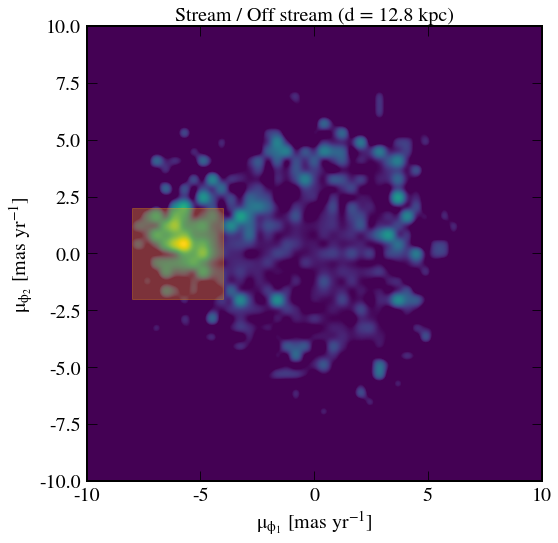

In [14]:
bx = np.linspace(-10,10,50)
Hon, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[phi2_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

Hoff, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

Hratio = np.zeros_like(Hon)
Hratio[Hoff>0] = Hon[Hoff>0] / Hoff[Hoff>0]
Hratio[Hratio==0] = 0.1

plt.imshow(Hratio.T, origin='lower', extent=[-10,10,-10,10], norm=mpl.colors.LogNorm(), vmin=1,
          interpolation='gaussian')

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Stream / Off stream (d = {:.1f} kpc)'.format(d0), fontsize='medium')

plt.tight_layout()

In [ ]:
for d0 in np.arange(12.6,14.1,0.2):
    cj = c.transform_to(Jhelum)
    cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

    # Correct for reflex motion
    v_sun = coord.Galactocentric.galcen_v_sun
    observed = cj_dist.transform_to(coord.Galactic)
    rep = observed.cartesian.without_differentials()
    rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
    cj = coord.Galactic(rep).transform_to(Jhelum)
    
    # check proper motion space
    bx = np.linspace(-10,10,50)
    Hon, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
             cj.pm_phi2[phi2_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

    Hoff, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
             cj.pm_phi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

    Hratio = np.zeros_like(Hon)
    Hratio[Hoff>0] = Hon[Hoff>0] / Hoff[Hoff>0]
    Hratio[Hratio==0] = 0.1

    plt.close()
    plt.figure(figsize=(8,8))
    plt.imshow(Hratio.T, origin='lower', extent=[-10,10,-10,10], norm=mpl.colors.LogNorm(), vmin=1,
              interpolation='gaussian')

    rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
    rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
    rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
    pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='w', alpha=0.1)
    plt.gca().add_artist(pr)

    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
    plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
    plt.title('Stream / Off stream (d = {:.1f} kpc)'.format(d0), fontsize='medium')

    plt.tight_layout()
    plt.savefig('../plots/jhelum_pm_dist.{:.1f}.png'.format(d0), dpi=200)

In [ ]:
for d1,d2 in [[12,14],[12.5,13.5],[13.5,12.5],[14,12]]:
    cj = c.transform_to(Jhelum)
    cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d1=d1, d2=d2),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

    # Correct for reflex motion
    v_sun = coord.Galactocentric.galcen_v_sun
    observed = cj_dist.transform_to(coord.Galactic)
    rep = observed.cartesian.without_differentials()
    rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
    cj = coord.Galactic(rep).transform_to(Jhelum)
    
    # check proper motion space
    bx = np.linspace(-10,10,50)
    Hon, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
             cj.pm_phi2[phi2_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

    Hoff, bex, bey = np.histogram2d(cj.pm_phi1_cosphi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
             cj.pm_phi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), bins=bx)

    Hratio = np.zeros_like(Hon)
    Hratio[Hoff>0] = Hon[Hoff>0] / Hoff[Hoff>0]
    Hratio[Hratio==0] = 0.1

    plt.close()
    plt.figure(figsize=(8,8))
    plt.imshow(Hratio.T, origin='lower', extent=[-10,10,-10,10], norm=mpl.colors.LogNorm(), vmin=1,
              interpolation='gaussian')

    rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
    rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
    rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
    pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='w', alpha=0.1)
    plt.gca().add_artist(pr)

    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
    plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
    plt.title('Stream / Off stream (d1 = {:.1f} kpc, d2 = {:.1f} kpc)'.format(d1, d2), fontsize='medium')

    plt.tight_layout()
    plt.savefig('../plots/jhelum_pm_distgrad.{:.1f}.{:.1f}.png'.format(d1,d2), dpi=200)

In [15]:
# adopt 13kpc
d0 = 13

cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [16]:
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (cj.phi2<-3*u.deg) & (cj.phi2>-4*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)

points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

## Position in the Galaxy

In [17]:
cgal = cj_dist.transform_to(coord.Galactocentric)

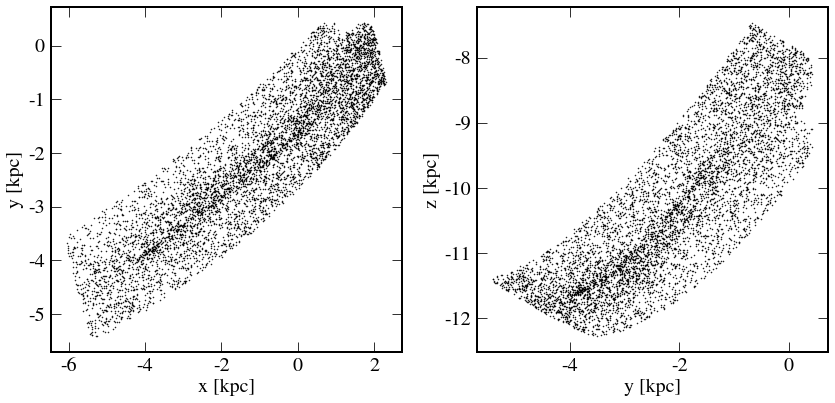

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

plt.sca(ax[0])
plt.plot(cgal.x[pm_mask & cmd_mask], cgal.y[pm_mask & cmd_mask], 'k.', ms=1)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')

plt.sca(ax[1])
plt.plot(cgal.y[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask], 'k.', ms=1)

plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')

plt.tight_layout()
# plt.savefig('../plots/jhelum_galactocentric.png', dpi=150)

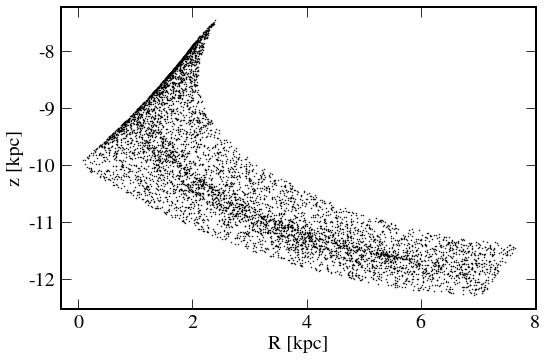

In [19]:
rgal = np.sqrt(cgal.x**2 + cgal.y**2)
plt.plot(rgal[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask], 'k.', ms=1)
plt.gca().set_aspect('equal')
# plt.quiver(Rin, zin, vcomb_pix[:,0], vcomb_pix[:,1], pivot='middle', 
#            headwidth=0, headlength=0, headaxislength=0, scale=0.02, scale_units='xy')
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')

plt.tight_layout()

In [20]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5,0,'Z (kpc)')

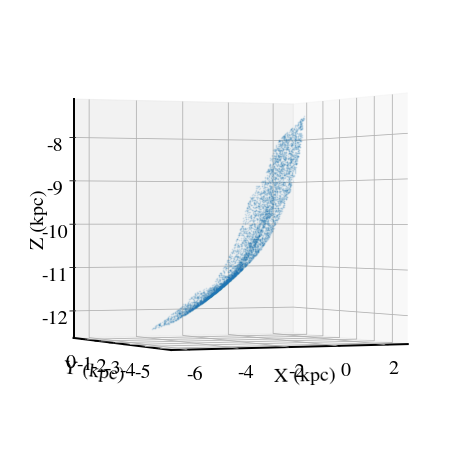

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

# ax.view_init(azim=120, elev=30)
ax.view_init(azim=245, elev=0)
ax.set_frame_on(False)

ax.scatter(cgal.x[pm_mask & cmd_mask], cgal.y[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask], 
           'o', depthshade=False, alpha=0.1, s=1)

ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')

In [24]:
tout = Table([cgal.x[pm_mask & cmd_mask], cgal.y[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask]], 
            names=('x', 'y', 'z'))

In [26]:
tout.write('../data/pos_galactocentric.fits', overwrite=True)

## Brutus inputs

In [27]:
tbrut = Table([g.l, g.b, g.parallax, g.parallax_error, g.phot_g_mean_mag, g.phot_g_mean_flux_over_error,
              g.phot_bp_mean_mag, g.phot_bp_mean_flux_over_error, g.phot_rp_mean_mag, g.phot_rp_mean_flux_over_error,
              g.g, g.g_error, g.r, g.r_error, g.i, g.i_error],
              names=('glon', 'glat', 'parallax', 'parallax_error', 'Gaia_G_DR2Rev', 'Gaia_G_DR2Rev_sig',
                     'Gaia_BP_DR2Rev', 'Gaia_BP_DR2Rev_sig', 'Gaia_RP_DR2Rev', 'Gaia_RP_DR2Rev_sig', 'DECam_g',
                    'DECam_g_sig', 'DECam_r', 'DECam_r_sig', 'DECam_i', 'DECam_i_sig'))

In [30]:
tbrut[pm_mask & cmd_mask].write('../data/jhelum_brutus_input.fits', overwrite=True)

In [31]:
tbrut_in = Table.read('../data/jhelum_brutus_input.fits')

In [35]:
len(tbrut_in)*8/3600

14.275555555555556